In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

In [2]:
userEngagement = pd.read_csv('takehome_user_engagement.csv',encoding='latin-1')
users = pd.read_csv('takehome_users.csv',encoding='latin-1')

In [3]:
userEngagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [6]:
users['creation_time'] = pd.to_datetime(users['creation_time'])

In [7]:
userEngagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [8]:
userEngagement['time_stamp'] = pd.to_datetime(userEngagement['time_stamp'])

In [9]:
def logins_in_days(df, days=7, logins=3):
    # drop dupes and sort
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    # calculate days has passed for every 3 logins
    passed_days = df['date'].diff(periods=logins-1)
    # check if any passed time is less than 7 days
    return any(passed_days <= timedelta(days=days))

In [10]:
adopted = userEngagement.groupby('user_id').apply(logins_in_days)

In [11]:
len(adopted)

8823

In [12]:
len(users)

12000

There are some users in our users dataframe who don't show up on our user engagment dataframe so we need to reconstruct a full adopted list to be added as a column to the users dataframe.

In [13]:
adoptedToAdd = []
for i in range(len(users)):
    tempID = users['object_id'].iloc[i]
    try:
        if adopted[tempID] == True:
            adoptedToAdd.append(True)
        else:
            adoptedToAdd.append(False)
    except:
        adoptedToAdd.append(False)
len(adoptedToAdd)

12000

In [14]:
users['adopted_user'] = adoptedToAdd

In [15]:
users['adopted_user'].value_counts()

False    10344
True      1656
Name: adopted_user, dtype: int64

We can see that 1656 of our total 10344 registered members are adopted members giving us an adoption rate of about 16%

In [16]:
# create a feature of user history
# convert both time features into datetime
users['creation_time'] = pd.to_datetime(
    users['creation_time'], format='%Y-%m-%d %H:%M:%S')
users['last_session_creation_time'] = pd.to_datetime(
    users['last_session_creation_time'], unit='s')
# calculate user history, defined as number of days between account creation and last use
users['history'] = users['last_session_creation_time'] - users['creation_time']
users['history'] = users['history'].dt.days
# calculate account age, defined as number of days since account creation and now
latest = max(users['creation_time'])
users['account_age'] = latest - users['creation_time']
users['account_age'] = users['account_age'].dt.days
# drop the two original columns
users = users.drop(['creation_time', 'last_session_creation_time'], axis=1)

In [17]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   name                        12000 non-null  object 
 2   email                       12000 non-null  object 
 3   creation_source             12000 non-null  object 
 4   opted_in_to_mailing_list    12000 non-null  int64  
 5   enabled_for_marketing_drip  12000 non-null  int64  
 6   org_id                      12000 non-null  int64  
 7   invited_by_user_id          6417 non-null   float64
 8   adopted_user                12000 non-null  bool   
 9   history                     8823 non-null   float64
 10  account_age                 12000 non-null  int64  
dtypes: bool(1), float64(2), int64(5), object(3)
memory usage: 949.3+ KB


In [18]:
#invited by user id is going to give us lots of problems so we drop that column
users.drop('invited_by_user_id',axis=1,inplace=True)
users.dropna(inplace=True)

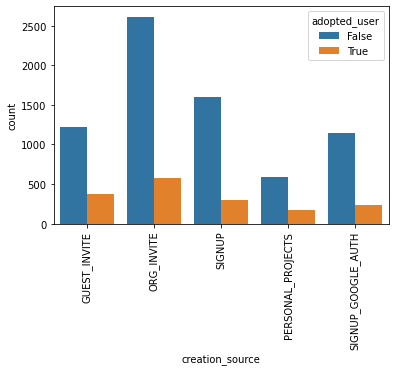

In [19]:
# Creation source and adopted user
sns.countplot(x='creation_source', data=users, hue='adopted_user')
plt.xticks(rotation=90)
plt.show()

There doesn't seem to be a significant correlation between sign up method and user adoption.

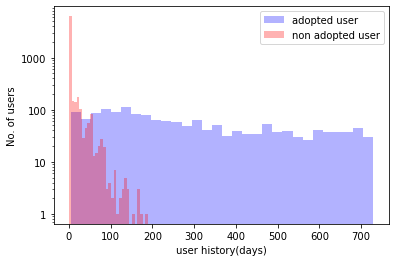

In [20]:
# history and adopted user
def plot_hist_days(df, col, xlabel):
    plt.hist(df.loc[users['adopted_user']==1, col], 
                 bins=30, alpha=0.3, color='b', label='adopted user')
    plt.hist(df.loc[users['adopted_user']==0, col], 
                 bins=30, alpha=0.3, color='r', label='non adopted user')
    plt.yscale('log')
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel('No. of users')
    plt.yticks([1, 10, 100, 1000], ['1', '10', '100', '1000'])
plot_hist_days(users, 'history', 'user history(days)')

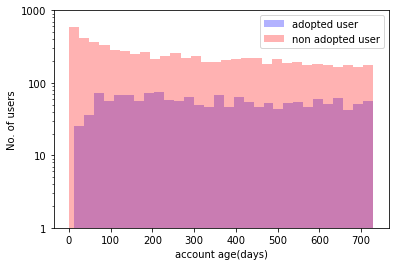

In [21]:
plot_hist_days(users, 'account_age', 'account age(days)')

We can see that users with a longer history are more likely to be adopted users which follows the intuitive thought process. We also can see that while older accounts are more likely to adopt than younger accounts, the rate hasn't changed much.

In [22]:
# make dummy variable for creation source
creation_source = pd.get_dummies(users['creation_source'], drop_first=True)
model_data = pd.concat([users, creation_source], axis=1).drop('creation_source', axis=1)
y = model_data['adopted_user']
X = model_data.drop(['name','email','adopted_user'], axis=1)
# create training and testing sets
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, stratify=y, random_state=42)

In [23]:
# use random forest model with balanced class weights to correct for imbalance in the data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
# use CV to tune number of trees
params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params)
model.fit(Xtrain, ytrain)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'n_estimators': 100}
Best average precision was 0.9656945557679265


In [25]:
# evluation of the model
from sklearn.metrics import classification_report, accuracy_score
model = RandomForestClassifier(
    random_state=42, class_weight='balanced', n_estimators=100
)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
print('Accuracy of test set was', accuracy_score(ytest, ypred))
print(classification_report(ytest, ypred))

Accuracy of test set was 0.9587488667271079
              precision    recall  f1-score   support

       False       0.97      0.98      0.97      1792
        True       0.91      0.87      0.89       414

    accuracy                           0.96      2206
   macro avg       0.94      0.92      0.93      2206
weighted avg       0.96      0.96      0.96      2206



In [26]:
# take a look at feature importance
imp = pd.Series(model.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

history                       0.853370
account_age                   0.057134
org_id                        0.039000
object_id                     0.033111
SIGNUP                        0.003298
opted_in_to_mailing_list      0.003184
ORG_INVITE                    0.003079
enabled_for_marketing_drip    0.003064
SIGNUP_GOOGLE_AUTH            0.002511
PERSONAL_PROJECTS             0.002248
dtype: float64


Clearly history is the most important feature by far. I would recommend the company implement some sort of policy that incentivises frequent log in as getting users who have a history with the product tend to use it multiple times a week.